# Distribution of Insolation

This notebook implements some equations from Appendix A of [Hartmann 2016](https://www.elsevier.com/books/global-physical-climatology/hartmann/978-0-12-328531-7) and attemps to draw Fig. 2.6.

Import neccesary modules and define constants and parameters. $\tau\equiv 2\pi$.

In [1]:
from math import tau, pi # tau = 2 * pi
import numpy as np
from numba import vectorize, float64

pih = pi / 2
nd = 365 # revolution period in days
ecc = 0.0167086 # eccentricity
perihelion = 2 # offset of perihelion in days. varies each year
doy = np.arange(365)
S0 = 1360 # solar constant

## Declination Angle

The time of year in radian (A.5)
\begin{equation}
\theta_\mathrm{d} = \frac{\tau d_n}{365}\;\mathrm{(A.5)}
\end{equation}

The declination angle $\delta$ is obtained by the inner product of the unit vector of the rotation axis of the earth $(0, -\sin\varepsilon, 0)$ and the unit vector of poiting the Sun $(-\cos\lambda, -\sin\lambda, 0)$ to be
\begin{equation}
\cos(\pi/2-\delta) = \sin\delta=\sin\lambda\sin\varepsilon
\end{equation}
where $\varepsilon$ is the obliquity $\lambda$ is the ecliptic longitude.
The obliquity is an angle between the ecliptic and equatorial planes.
The ecliptic longitude is an angle measured from the Vernal Equinox.

A convenient the Fourier form (A.6) is used here.

In [2]:
@vectorize([float64(float64)])
def  doy2angle(doy):
    return tau * doy / nd

@vectorize([float64(float64)])
def declination_angle(doy):
    an = np.array([0.006918, -0.399912, -0.006758, -0.002697])
    bn = np.array([0.0,       0.070257,  0.000907,  0.001480])
    theta  = np.arange(an.size) * doy2angle(doy)
    return an @ np.cos(theta) + bn @ np.sin(theta)

In [3]:
from matplotlib import pyplot as plt

delta = declination_angle(doy)

plt.plot(doy, np.rad2deg(delta))

## Distance from the Sun to Earth
The distance from the Sun to Earth is given by the following formula.
\begin{equation}
r = \frac{a(1-e^{2})}{1 + e\cos\theta}
\end{equation}
where $a$ is the semi-major axis and $e$ the eccentricity, and $\theta$ the angle from the perihelion.

In [4]:
@vectorize([float64(float64)])
def distance(doy):
    theta  = doy2angle(doy - perihelion)
    return (1 - ecc * ecc) / (1 + ecc * np.cos(theta))

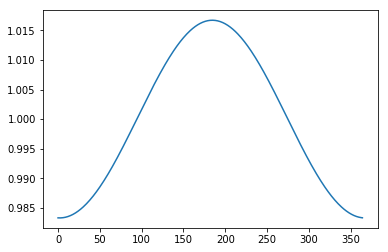

In [5]:
dist = distance(doy)
squared_dbar_over_d = (1.0 / dist) ** 2
plt.plot(doy, dist)

Alternatively the following Fourier formula may be used.

In [6]:
@vectorize([float64(float64)])
def squared_inverse_of_normalized_distance(doy):
    an = np.array([1.000110, 0.034221, 0.000719])
    bn = np.array([0.0,      0.001280, 0.000077])
    theta  = np.arange(an.size) * doy2angle(doy)
    return an @ np.cos(theta) + bn @ np.sin(theta)

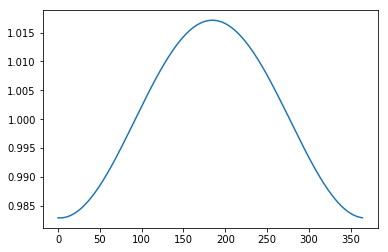

In [7]:
squared_dbar_over_d = squared_inverse_of_normalized_distance(doy)
plt.plot(doy, np.sqrt(1.0 / squared_dbar_over_d))

Let the distance from the Sun to be $r$ and the angle from the major axis to be $\theta$. Becase the sum of the distances from the two forci is equal to $2a$, the distance from the other focus is $2a - r$. Apply the cosine theorem to the triangle formed by the two foci and the point on the ellipse. Noting that the distance between the two foci is $2c$
\begin{align}
(2a - r)^2 &= r^2 + (2c)^2 - 4cr\cos(\pi-\theta)
a^2 - ar = c^2 + cr\cos\theta
\end{align}.
Substituting $r\cos\theta = x - c$, we obtain
\begin{equation}
r = \frac{a^2 - cx}{a}
\end{equation}
The average of $r$ is
\begin{equation}
\bar{d} = \frac{1}{2a}\int_{-a}^a\frac{a^2-cx}{a}\mathrm{d}x = a
\end{equation}

Thus the mean distance from the Sun $\bar{d}$ is equal to the semi-major axis $a$, or the arithmetic average of the distances at the Perihelion $r_\mathrm{p}$ and the Aphelion $r_\mathrm{a}$.
\begin{equation}
\bar{d} = a = \frac{r_\mathrm{p} + r_\mathrm{p}}{2}
\end{equation}

## Duration of daytime
The hour angle is defined by the angle relative to the noon.
\begin{equation}
h = \tau \frac{t}{24} \mod \tau - \pi
\end{equation}
where time $t$ in hours.

In [8]:
@vectorize([float64(float64)])
def hour_angle(hr):
    return tau * hr / 24 % tau - pi

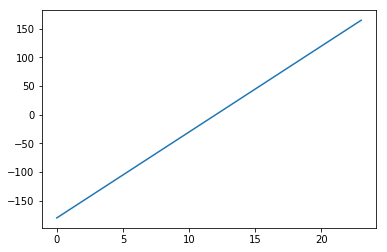

In [9]:
hr = np.arange(0, 24)

plt.plot(hr, np.rad2deg(hour_angle(hr)))

The sunrise and sunset correspond to the solar zeith angles $\pm\pi/2$, the hour angle between the noon and the sunrise sunset is
\begin{equation}
\cos h_0 = -\tan\phi\tan\delta
\end{equation}

Note that $\tan\phi$ become very large in the polar regions. The polar night and white night needs to be excluded.

In [10]:
def half_day(lat, delta):
    if delta > 0:
        if lat >= pih - delta:
            return pi
        elif lat <= -pih + delta:
            return 0
        else:
            return np.arccos(-np.tan(lat) * np.tan(delta))
    elif delta < 0:
        if lat >= pih + delta:
            return 0
        elif lat <= -pih - delta:
            return pi
        else:
            return np.arccos(-np.tan(lat) * np.tan(delta))
    else:
        return pih

First, draw a plot of the half daytime at Kyoto or anywhere at 35N.
Because the inverse of the hour angle equation give the sunset, 12 hours is subtracted.

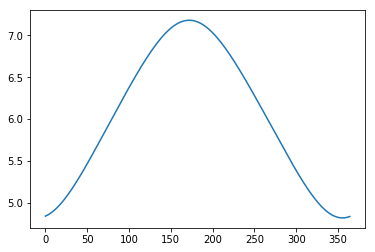

In [11]:
lat = np.deg2rad(35)
h0 = np.zeros(nd)
for i in np.arange(nd):
    h0[i] = half_day(lat, delta[i])
plt.plot(doy, 24 * (h0 + pi) / tau - 12)

Next, draw the contour plot for all latitudes.

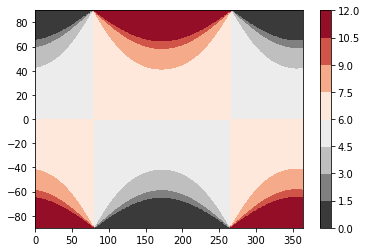

In [12]:
nlat = 91
lat = np.linspace(-np.pi/2, np.pi/2, nlat)
x, y = np.meshgrid(doy, lat)
h0 = np.zeros((nlat, nd))
for j in np.arange(nlat):
    for i in np.arange(nd):
        h0[j, i] = half_day(lat[j], delta[i])
cnt = plt.contourf(x, np.rad2deg(y), 24 * (h0 + pi) / tau - 12, cmap="RdGy_r")
plt.colorbar(cnt)

## Daily average insolation
Finally draw the daily averarge insolation (Fig. 2.6).
\begin{equation}
\bar{Q}^\mathrm{day} = \frac{S_0}{\pi}\left(\frac{\bar{d}}{d}\right)^2(h_0\sin\phi\sin\delta+\cos\phi\cos\delta\sin h_0)\; \mathrm{(2.17)}
\end{equation}

In [13]:
def q_dailymean(lat, dd, delta):
    h0 = half_day(lat, delta)
    return S0 / pi * dd * \
        (h0 * sinlat * np.sin(delta) +  coslat * np.cos(delta) * np.sin(h0))

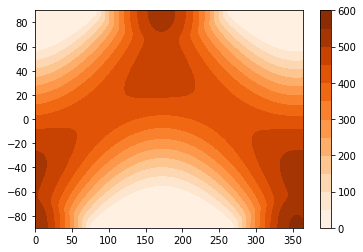

In [14]:
qbar = np.zeros((nlat, nd))
for j in np.arange(nlat):
    sinlat = np.sin(lat[j])
    coslat = np.cos(lat[j])
    for i in np.arange(nd):
        qbar[j, i] = q_dailymean(lat[j], squared_dbar_over_d[i], delta[i])
cnt = plt.contourf(x, np.rad2deg(y), qbar, np.linspace(0, 600, 13), cmap="Oranges")
plt.colorbar(cnt)